Text classification

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#% matplotlib inline

In [19]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [20]:
df_train = pd.read_csv('agreement-sentence-agreement-DFE.csv', header=0, encoding = 'unicode_escape')


In [21]:
df_train.head()

,_unit_id,_unit_state,_trusted_judgments,_last_judgment_at,truth_response,truth_response:confidence,hypothesis,premise,truth_response_gold
0,679986253,finalized,5,2/22/15 0:32,yes,1.0000,Woman pushing a bicycle.,A woman in summer attire is walking with her b...,NaN
1,679986254,finalized,5,2/22/15 0:50,yes,1.0000,Woman pushing a bicycle.,"A girl in a white shirt, walking beside her bike.",NaN
2,679986255,finalized,5,2/22/15 1:47,yes,1.0000,Woman pushing a bicycle.,A woman walking a bike down a busy sidewalk.,NaN
3,679986256,finalized,5,2/22/15 1:13,no,0.6121,Woman pushing a bicycle.,A woman carrying her bike through a crowd.,NaN
4,679986257,finalized,5,2/22/15 0:46,yes,0.5831,A man sitting on an animal.,A boy rides a horse down a dusty country road.,NaN


In [22]:
from io import StringIO

col = ['truth_response', 'premise']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['premise'])]
df_train.columns = ['truth_response', 'premise']

df_train['category_id'] = df_train['truth_response'].factorize()[0]

category_id_df_train = df_train[['truth_response', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'truth_response']].values)

df_train.head()

,truth_response,premise,category_id
0,yes,A woman in summer attire is walking with her b...,0
1,yes,"A girl in a white shirt, walking beside her bike.",0
2,yes,A woman walking a bike down a busy sidewalk.,0
3,no,A woman carrying her bike through a crowd.,1
4,yes,A boy rides a horse down a dusty country road.,0


In [23]:
premise = ['A woman walking a bike down a busy sidewalk', 'A woman carrying her bike through a crowd.']

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df = 0, lowercase = False)
vectorizer.fit(premise)

vectorizer.vocabulary_

{'woman': 9,
 'walking': 8,
 'bike': 0,
 'down': 4,
 'busy': 1,
 'sidewalk': 6,
 'carrying': 2,
 'her': 5,
 'through': 7,
 'crowd': 3}

In [25]:
vectorizer.transform(premise).toarray()

array([[1, 1, 0, 0, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 1, 0, 1, 0, 1]])

In [69]:
from sklearn.model_selection import train_test_split

premise = df_train['premise'].values
y = df_train['category_id'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(premise, y, test_size = 0.25,
                                                                   random_state = 1000)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

X_train

<1500x2047 sparse matrix of type '<class 'numpy.int64'>'
	with 15504 stored elements in Compressed Sparse Row format>

The classification model we are going to use is the Logistic Regression 

In [71]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.562


Deep Neural Networks 

In [72]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1] #Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim = input_dim, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

Before you can start with the training of the model, you need to configure the learning process.
This is done with the .compile() method.

In [73]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                20480     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 20,491
Trainable params: 20,491
Non-trainable params: 0
_________________________________________________________________


Now it is time to start your training with the .fit() function

Since the training in neural networks is an iterative process, 
the training won't just stop after its done. These complited iterations are commonly called epochs. Another parameteryou have to your selection is the batch size.

In [74]:
history = model.fit(X_train, y_train,
                   epochs = 100,
                   verbose = False,
                   validation_data = (X_test, y_test),
                   batch_size = 10)

Now you can use the .evaluate() method to measure the accuracy of the model. You can do this both
for the training data and testing data.

In [77]:
loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8167


In [78]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Testing Accuracy: 0.5280


Visualize the loss and accuracy for the training and testing data based on the history call back

In [79]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss =history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc,  'b', label = 'Training acc')
    plt.plot(x, val_acc, 'r', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label = 'Training loss')
    plt.plot(x, val_loss, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    
    plt.legend()
    
    

Call plot_history() with the collected accuracy and loss inside the history dictionary

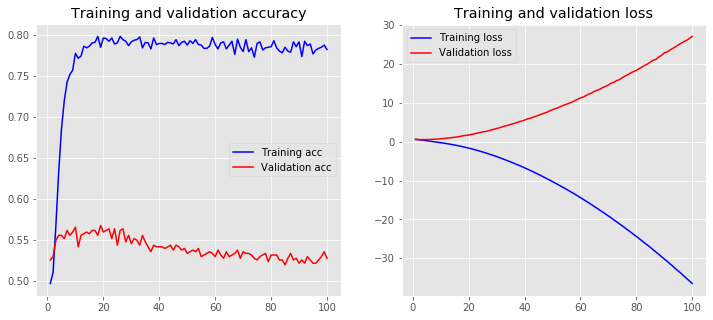

In [80]:
 plot_history(history)

Word Embedding

This method represents words as dense word vectors (also called words embeddings) which are trained
unlike the one-hot encoding which are hardcoded.This means that the word embeddings collect more
information into fewer dimensions.

In [81]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


X_train = tokenizer.texts_to_sequences(sentences_train)

X_test = tokenizer.texts_to_sequences(sentences_test)

In [82]:
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(sentences_train)   #(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)



#X_test =  tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1    # Adding 1 because reserved 0 index

print(sentences_train[2])
print(X_train[2])

A group of people waiting to ride boats.
[1, 26, 7, 13, 167, 15, 351, 773]


In [83]:
for word in ['of', 'waiting', 'to', 'boats']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

of: 7
waiting: 167
to: 15
boats: 773


Additionally you would want to add a maxlen parameter to specify how long the sequences
should be. 

In [84]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Keras Embedding Layer

You can use the Embedding Layer of Keras which takes the previously calculated integers and maps
them to a dense vector of the embedding

In [85]:
from keras.models import Sequential
from keras import layers

In [87]:
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim,
                          input_length = maxlen))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           103650    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 153,671
Trainable params: 153,671
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 103650 new parameters to train. This number comes from vocab_size
times the embedding_dim.

In [89]:
history = model.fit(X_train, y_train,
                   epochs = 20,
                   verbose = False,
                   validation_data = (X_test, y_test),
                   batch_size = 10)

loss, accuracy = model.evaluate(X_train, y_train, verbose = False)
print('Training Accuracy: {:.4f}'.format(accuracy))


Training Accuracy: 0.8107


In [90]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)
print('Testing Accuracy: {:.4f}'.format(accuracy))

Testing Accuracy: 0.5420


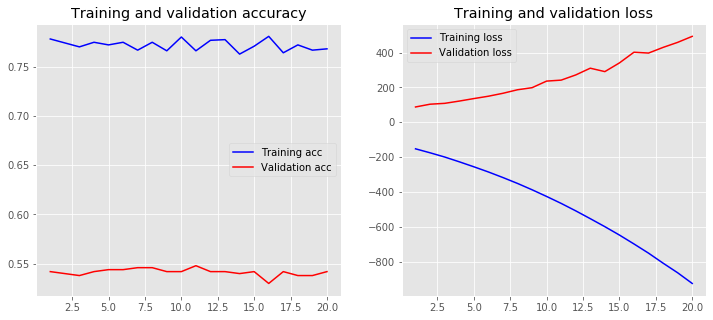

In [91]:
plot_history(history)

Another way to to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a 
GlobalMaxPooling/GlobalAveragePooling1D layer after the embedding.

In [93]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim,
                          input_length = maxlen))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           103650    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 104,171
Trainable params: 104,171
Non-trainable params: 0
_________________________________________________________________


The procedure for training does not change

In [94]:
history = model.fit(X_train, y_train,
                   epochs = 50,
                   verbose = False,
                   validation_data = (X_test, y_test),
                   batch_size = 10)

loss, accuracy = model.evaluate(X_train, y_train, verbose = False)

print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8320


In [95]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = False)

print("Testing Accuracy: {:.4f}".format(accuracy))

Testing Accuracy: 0.5620
